# MaMBa Data Manipulation


### Import all data files and create one sorted data frame without duplicates

In [1]:
# Clear variables
%reset -f

import numpy as np
import pandas as pd
import glob
import os

pwd = %pwd
data_path = pwd + "/data/"

all_files = glob.glob(os.path.join(data_path, "*.csv")) # make list of paths
mData = pd.DataFrame(pd.read_csv(all_files[0]))         # create a DataFrame to start with (0 doesn't mather, remove duplicates later)

# set order of columns and exercises
cols = ['ID',' Övning',' Utrustning',' Höger/Vänster',' Försök_1',' Försök_2',' Försök_3',' Försök_4',' Försök_5',' Försök_6',' Försök_7',' Försök_8',' Försök_9',' Försök_10']
exercises = [' Snabba vändningar fot', ' Tennisboll över bom', ' Droppboll', ' Jonglera med armbåge', ' Kasta och fånga', ' Jonglera mot vägg', ' Kanonen', ' Jonglera med knä', ' Studsa basket', ' Balansera bollen', ' Minigolf', ' Snabba vändningar klubba']

# add all .csv files to our DataFrame
for file in all_files:
    mData_temp = pd.DataFrame(pd.read_csv(file))
    mData = pd.concat((mData, mData_temp), ignore_index = False)
mData = mData[cols].reset_index()

# change the exercise name for ' Snabba vändningar' so that it is two separate exercises. Needed for reindex later.
for i in range(0,len(mData)):
    if mData.loc[i,' Övning'] == ' Snabba vändningar':
        mData.loc[i,' Övning'] = ' Snabba vändningar'+mData.loc[i,' Utrustning']

# sort the data by ID and Övning. Input NaN:s when missing exercise.
mData = mData.drop_duplicates(subset=['ID', ' Övning'], keep='last') # remove duplicates
mData[' Övning'] = mData[' Övning'].astype("category", categories=exercises, ordered=True) # set an order for Övning
mData = mData.sort_values(['ID',' Övning'])
multi_index = pd.MultiIndex.from_product([mData['ID'].unique(), exercises], names=['ID', ' Övning'])
mData = mData.set_index(['ID', ' Övning']).reindex(multi_index).reset_index() # input NaN:s

print("Number of unique exercises: "+str(len(mData)))

Number of unique exercises: 1752


### Fix wrong equipment markup on some exercises

In [2]:
for i in range(0,len(mData)):
    if mData.loc[i,' Övning'] == ' Jonglera med armbåge':
        if mData.loc[i,' Utrustning'] == ' hand':
            mData.loc[i,' Utrustning'] = ' armbåge'
    if mData.loc[i,' Övning'] == ' Jonglera med knä':
        if mData.loc[i,' Utrustning'] == ' fot':
            mData.loc[i,' Utrustning'] = ' armbåge'
    if mData.loc[i, ' Övning'] == ' Balansera bollen':
        if mData.loc[i,' Utrustning'] == ' rack':
            mData.loc[i,' Utrustning'] == ' slagträ'

### Make large dataframe with one row for each ID

In [3]:
# put all exercises with same ID on the same row
mDataLarge = mData.set_index(['ID', mData.groupby('ID').cumcount()])[cols[1:len(cols)]].unstack().add_prefix('').reset_index()
mDataLarge.columns = [' '.join(col).strip() for col in mDataLarge.columns.values] # rename columns

# whitout space in the beginning
cols2 = ['ID','Övning','Utrustning','Höger/Vänster','Försök_1','Försök_2','Försök_3','Försök_4','Försök_5','Försök_6','Försök_7','Försök_8','Försök_9','Försök_10']
exercises2 = [''.join(ovn).strip() for ovn in exercises]

# Rearrange the data
columns = ['ID']
for i in range(0,12):
    for col in cols2[1:len(cols2)]:
        columns.append((col+" "+str(i)))
mDataLarge = mDataLarge[columns]

# Rename the column names
cols2 = ['ID','Övning','Utrustning','Höger/Vänster','#1','#2','#3','#4','#5','#6','#7','#8','#9','#10']
columns = ['ID']
for ovn in exercises2:
    for col in cols2[1:len(cols2)]:
        columns.append((ovn+", "+col))
mDataLarge.columns = columns

# Delete unnecessary columns
columns_good = ['ID']
nrOfAttempts = [10, 1, 7, 3, 2, 3, 1, 3, 2, 3, 6, 10]
for ovn in exercises2:
    for col in cols2[2:(4+nrOfAttempts[exercises2.index(ovn)])]:
        if (col=='Höger/Vänster' and ovn=='Minigolf') or col!='Höger/Vänster':
            columns_good.append((ovn+", "+col))
columns_remove = [col for col in columns if col not in columns_good]
#columns_remove.append(['Droppboll, #1','Droppboll, #2'])  # remove first two attempts (tests)? 
for col in columns_remove:
    mDataLarge = mDataLarge.drop(col, axis=1)

# Save to csv-file
mDataLarge.to_csv('mDataLarge.csv', index=False)




### Make small dataframe (mean values etc.) with one row for each ID

In [4]:
for i in cols[4:14]:
    mData[i] = pd.to_numeric(mData[i], errors = 'coerce')



mDataSmall = mData.reset_index(drop = True)
mDataSmall = pd.DataFrame(mDataSmall)


def exer_check(data_mat, col_name, ovn_name): # 
    return data_mat.loc[data_mat[col_name] == ovn_name]


# Best value (Tennisboll över bom, Jonglera med armbåge, Kasta och fånga, Jonglera mot vägg, Kanonen, 
# Jonglera med knä, Studsa basket, Balansera bollen)
mDataBest = exer_check(mDataSmall, ' Övning', ' Jonglera mot vägg')
mDataBest2 = exer_check(mDataSmall, ' Övning', ' Jonglera med knä')
mDataBest3 = exer_check(mDataSmall, ' Övning', ' Jonglera med armbåge')
mDataBest4 = exer_check(mDataSmall, ' Övning', ' Tennisboll över bom')
mDataBest5 = exer_check(mDataSmall, ' Övning', ' Kasta och fånga')
mDataBest6 = exer_check(mDataSmall, ' Övning', ' Kanonen')
mDataBest7 = exer_check(mDataSmall, ' Övning', ' Studsa basket')
mDataBest8 = exer_check(mDataSmall, ' Övning', ' Balansera bollen')
mDataBest = pd.concat((mDataBest, mDataBest2, mDataBest3, mDataBest4, mDataBest5, mDataBest6, mDataBest7, mDataBest8), ignore_index = False)

mDataBest = mDataBest.reset_index(drop = True) # Reset index
mDataBest['Resultat'] = [mDataBest.loc[i, " Försök_1":" Försök_10"].max() for i in range(0, len(mDataBest))] # Results for the exercises where only the best attempt counts



# Total value, snabba vändningar och minigolf
mDataTotal = exer_check(mDataSmall, ' Övning', ' Snabba vändningar fot')
mDataTotal2 = exer_check(mDataSmall, ' Övning', ' Snabba vändningar klubba')
mDataTotal3 = exer_check(mDataSmall, ' Övning', ' Minigolf')
mDataTotal = pd.concat((mDataTotal, mDataTotal2, mDataTotal3), ignore_index = False)

mDataTotal = mDataTotal.reset_index(drop = True) # Reset index
mDataTotal['Resultat'] = [mDataTotal.loc[i, " Försök_1":" Försök_10"].sum() for i in range(0, len(mDataTotal))] # Results for the exercises with all attempts as the result
mDataTotal = mDataTotal.drop('index', axis = 1)


# Droppboll, best 3 values
mDataDrop = exer_check(mDataSmall, ' Övning', ' Droppboll')
mDataDrop = pd.DataFrame(mDataDrop)
mDataDrop = mDataDrop.drop(['index', ' Försök_1', ' Försök_2'], axis = 1) 
mDataDrop = mDataDrop.reset_index(drop = True) # Reset index


def mean_three_low(i, array): # Function to summarize the three best attempts in droppboll
    temp = array.loc[i, ' Försök_3':' Försök_7']
    temp = temp.sort_values()
    return temp[0:3].mean()


mDataDrop['Resultat'] = [mean_three_low(i, mDataDrop) for i in range(0, len(mDataDrop))] # Result for droppboll


cols3 = ['ID',' Övning',' Utrustning',' Höger/Vänster', 'Resultat']

mDataSmall = pd.concat((mDataBest, mDataTotal, mDataDrop), ignore_index = False)
mDataSmall = mDataSmall[cols3].reset_index()
mDataSmall = mDataSmall.drop('index', axis = 1)



multi_index = pd.MultiIndex.from_product([mDataSmall['ID'].unique(), exercises], names=['ID', ' Övning'])
mDataSmall = mDataSmall.set_index(['ID', ' Övning']).reindex(multi_index).reset_index() # input NaN:s

# put all exercises with same ID on the same row
mDataSmall = mDataSmall.set_index(['ID', mDataSmall.groupby('ID').cumcount()])[cols3[1:len(cols3)]].unstack().add_prefix('').reset_index()
mDataSmall.columns = [' '.join(col).strip() for col in mDataSmall.columns.values] # rename columns


#cols4 = ['ID', 'Snabba vändningar fot', 'Tennisboll över bom', 'Droppboll', 'Jonglera med armbåge', 'Kasta och fånga', 'Jonglera mot vägg', 'Kanonen', 'Jonglera med knä', 'Studsa basket', 'Balansera bollen', 'Minigolf', 'Snabba vändningar klubba']


cols4 = ['ID', 'Höger/Vänster 10','Resultat 0', 'Resultat 1', 'Resultat 2', 'Resultat 3', 'Resultat 4', 'Resultat 5', 'Resultat 6', 'Resultat 7', 'Resultat 8', 'Resultat 9', 'Resultat 10', 'Resultat 11' ]
mDataSmall = mDataSmall[cols4]
cols5 = ['ID', 'Höger/Vänster', 'Snabba vändningar fot', 'Tennisboll över bom', 'Droppboll', 'Jonglera med armbåge', 'Kasta och fånga', 'Jonglera mot vägg', 'Kanonen', 'Jonglera med knä', 'Studsa basket', 'Balansera bollen', 'Minigolf', 'Snabba vändningar klubba']
mDataSmall.columns = cols5

# Save to csv-file
mDataSmall.to_csv('mDataSmall.csv', index=False)





## Histograms for the results

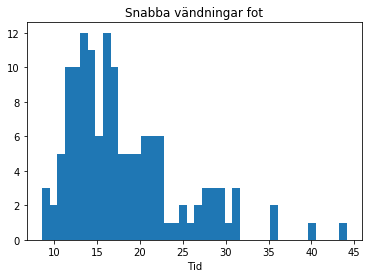

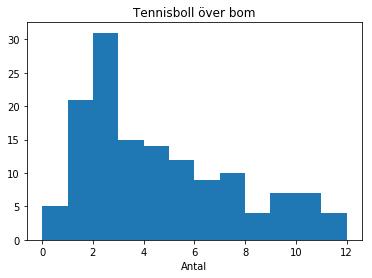

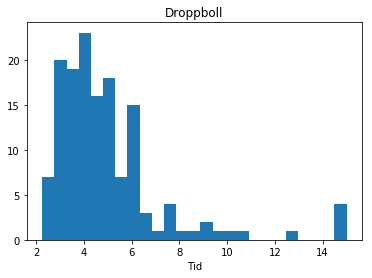

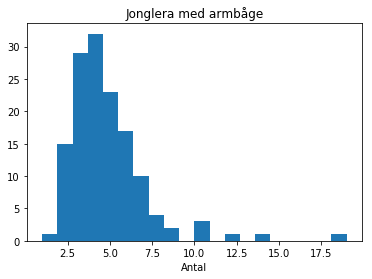

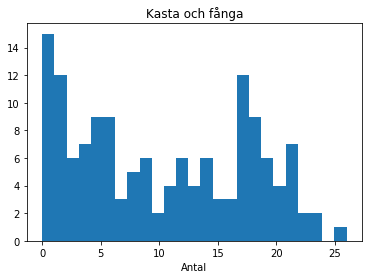

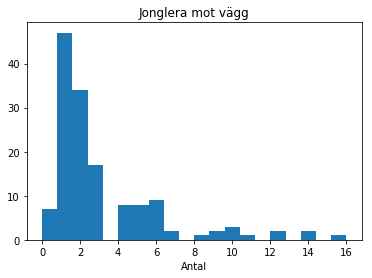

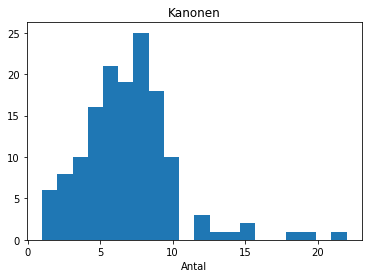

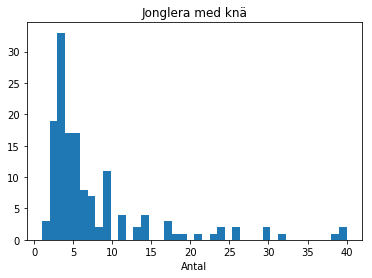

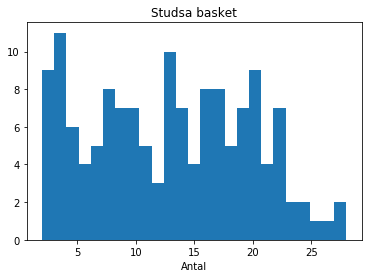

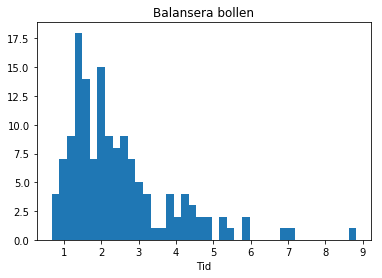

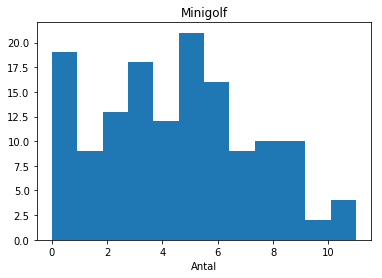

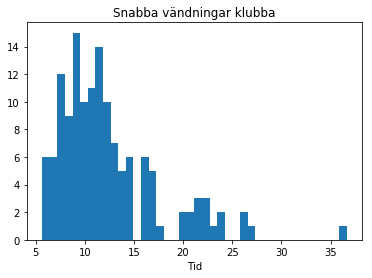

In [6]:
import matplotlib.pyplot as plt
path = pwd+'/graphs/'

# Snabba vändningar fot
plt.hist(mDataSmall['Snabba vändningar fot'].dropna(), bins = 40)
plt.title('Snabba vändningar fot')
plt.xlabel('Tid')
plt.savefig(path+'SnabbaFot.pdf')
plt.show()

# Tennisboll över bom
plt.hist(mDataSmall['Tennisboll över bom'].dropna(), bins = 12)
plt.title('Tennisboll över bom')
plt.xlabel('Antal')
plt.savefig(path+'Tennis.pdf')
plt.show()

# Droppboll
plt.hist(mDataSmall['Droppboll'].dropna(), bins = 25)
plt.title('Droppboll')
plt.xlabel('Tid')
plt.savefig(path+'Droppboll.pdf')
plt.show()

# Jonglera med armbåge
plt.hist(mDataSmall['Jonglera med armbåge'].dropna(), bins = 20)
plt.title('Jonglera med armbåge')
plt.xlabel('Antal')
plt.savefig(path+'Armbåge.pdf')
plt.show()

# Kasta och fånga
plt.hist(mDataSmall['Kasta och fånga'].dropna(), bins = 25)
plt.title('Kasta och fånga')
plt.xlabel('Antal')
plt.savefig(path+'KastaFånga.pdf')
plt.show()

# Jonglera mot vägg
plt.hist(mDataSmall['Jonglera mot vägg'].dropna(), bins = 20)
plt.title('Jonglera mot vägg')
plt.xlabel('Antal')
plt.savefig(path+'MotVägg.pdf')
plt.show()

# Kanonen
plt.hist(mDataSmall['Kanonen'].dropna(), bins = 20)
plt.title('Kanonen')
plt.xlabel('Antal')
plt.savefig(path+'Kanonen.pdf')
plt.show()

# Jonglera med knä
plt.hist(mDataSmall['Jonglera med knä'].dropna(), bins = 40)
plt.title('Jonglera med knä')
plt.xlabel('Antal')
plt.savefig(path+'MedKnä.pdf')
plt.show()

# Studsa basket
plt.hist(mDataSmall['Studsa basket'].dropna(), bins = 25)
plt.title('Studsa basket')
plt.xlabel('Antal')
plt.savefig(path+'Basket.pdf')
plt.show()

# Balansera bollen
plt.hist(mDataSmall['Balansera bollen'].dropna(), bins = 40)
plt.title('Balansera bollen')
plt.xlabel('Tid')
plt.savefig(path+'Balansera.pdf')
plt.show()

# Minigolf
plt.hist(mDataSmall['Minigolf'].dropna(), bins = 12)
plt.title('Minigolf')
plt.xlabel('Antal')
plt.savefig(path+'Minigolf.pdf')
plt.show()

# Snabba vändningar klubba
plt.hist(mDataSmall['Snabba vändningar klubba'].dropna(), bins = 40)
plt.title('Snabba vändningar klubba')
plt.xlabel('Tid')
plt.savefig(path+'SnabbaKlubba.pdf')
plt.show()